In [95]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

(3024, 4032, 3)


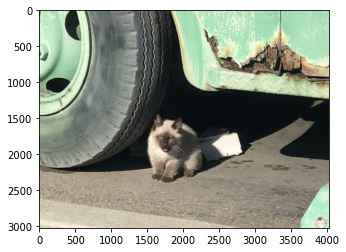

In [156]:
im = np.array(Image.open("Images/cat_photo.jpg"))
plt.imshow(im)
print(im.shape)

In [97]:
def pol2cart(r, t):
    return r*np.cos(t), r*np.sin(t)

def cart2pol(x, y):
    r = (x**2+y**2)**.5
    # t = np.pi/2*np.sign(y) if x == 0 else np.arctan(y/x)
    t = np.arctan2(y, x)
    return r, t

def backwards_warp(im, x, y):
    # mirror pad
    x += 1
    y += 1
    im = np.concatenate((im, im[:,-1][:,None]), axis=1)
    im = np.concatenate((im, im[-1,:][None]), axis=0)
    im = np.concatenate((im[:,0][:,None], im), axis=1)
    im = np.concatenate((im[0,:][None], im), axis=0)
    
    #get floor and ceiling
    xf = int(x)
    xc = int(x)+1
    yf = int(y)
    yc = int(y)+1
    try:
        #calc weighted average
        q1 = im[xf, yf] * (1-x+xf) * (1-y+yf)
        q2 = im[xc, yf] * (1-xc+x) * (1-y+yf)
        q3 = im[xc, yc] * (1-xc+x) * (1-yc+y)
        q4 = im[xf, yc] * (1-x+xf) * (1-yc+y)
        return q1+q2+q3+q4
    except:
        return False

In [98]:
i=np.array([[0, 90], [180, 255]])

print(backwards_warp(i, 0,0))
print(backwards_warp(i, 1,0))
print(backwards_warp(i, 0,1))
print(backwards_warp(i, 1,1))
print(backwards_warp(i, -.5,-.1))

0
180
90
255
0.0


In [99]:
def slow_swirl(im, k=1):
    warped = np.empty_like(im)
    x_mid = np.shape(im)[0]//2
    y_mid = np.shape(im)[1]//2
    inner = min(x_mid, y_mid)
    k *= min(x_mid, y_mid)
    
    for ind in tqdm(np.ndindex(im.shape[:2])):

        x = ind[0] - x_mid
        y = ind[1] - y_mid
        
        
        r, t = cart2pol(x, y)
        # if r > inner:
        #     continue
        t = t + (1-r/k)
        x_old, y_old = pol2cart(r, t)
            
        try:
            warped[ind] = im[int(x_old+x_mid), int(y_old+y_mid)]
        except:
            warped[ind] = im[ind]
        # new_val = backwards_warp(im, x_old, y_old)
        # warped[ind] = new_val if new_val is False else im[ind]
    return warped


# def fast_swirl(im, k=1):
#     warped = np.empty_like(im)
#     x_mid = np.shape(im)[0]//2
#     y_mid = np.shape(im)[1]//2
#     k *= min(x_mid, y_mid)*np.pi/2
    
#     grid_inds = np.fromfunction(lambda x, y: np.array([x-x_mid,y-y_mid]), im.shape)
#     grid_x = grid_inds[:,:,0]
#     grid_y = grid_inds[:,:,1]
#     r, t = cart2pol(grid_x, grid_y)
    
#     from_t = t + r/k
#     from_x, from_y = pol2cart(r, from_t)
    

In [23]:
def interpolate(im, pt):
    y, x = pt
    x = int(x)
    y = int(y)
    dy, dx = pt
    dx -= x
    dy -=y
    return im[y,x]*(1-dx)*(1-dy) + im[y+1,x]*(1-dx)*(dy) + im[y,x+1]*(dx)*(1-dy) + im[y+1,x+1]*(dx)*(dy)


def slow_swirl_wand(im, deg=20):
    deg *= np.pi/180
    warped = np.empty_like(im)
    x_mid = np.shape(im)[1]//2
    y_mid = np.shape(im)[0]//2
    
    x_scale = 1
    y_scale = 1
    if im.shape[1] > im.shape[0]:
        y_scale = im.shape[1]/im.shape[0]
    else:
        x_scale = im.shape[0]/im.shape[1]
        
    R = max(x_mid, y_mid)
    
    for ind in tqdm(np.ndindex(im.shape[:2])):
        y, x = ind
        x -= x_mid
        y -= y_mid
        
        d = x**2+y**2
        f = 1-d**.5/R
        cos = np.cos(deg*f**2)
        sin = np.sin(deg*f**2)
        x_prime= min((cos*x-sin*y)/x_scale+x_mid, im.shape[1]-2)
        y_prime= min((sin*x+cos*y)/y_scale+y_mid, im.shape[0]-2)
        warped[ind] = interpolate(im, (y_prime, x_prime))
        # new_val = backwards_warp(im, x_prime, y_prime)
    return warped

def faster_interp_swirl_wand(im, deg=20):
    deg *= np.pi/180
    warped = np.empty_like(im)
    x_mid = np.shape(im)[1]//2
    y_mid = np.shape(im)[0]//2
    
    x_scale = 1
    y_scale = 1
    if im.shape[1] > im.shape[0]:
        y_scale = im.shape[1]/im.shape[0]
    else:
        x_scale = im.shape[0]/im.shape[1]
        
    R = max(x_mid, y_mid)
    
    X = np.fromfunction(lambda y, x: x-x_mid, im.shape[:2])
    Y = np.fromfunction(lambda y, x: y-y_mid, im.shape[:2])
    D = X**2+Y**2
    F = 1-D**.5/R
    cos = np.cos(deg*F**2)
    sin = np.sin(deg*F**2)
    
    x_prime= ((cos*X-sin*Y)/x_scale+x_mid)
    y_prime= ((sin*X+cos*Y)/y_scale+y_mid)
    x_prime[x_prime > im.shape[1]-2] = im.shape[1]-2
    y_prime[y_prime > im.shape[0]-2] = im.shape[0]-2
    
    for ind in tqdm(np.ndindex(im.shape[:2])):
        y, x = ind
        x -= x_mid
        y -= y_mid
        warped[ind] = interpolate(im, (y_prime[ind], x_prime[ind]))
        # new_val = backwards_warp(im, x_prime, y_prime)
    return warped

In [143]:
def mat_interp(im, x, y):
    x_floor = x.astype('int')
    y_floor = y.astype('int')
    dx = x-x_floor
    dy = y-y_floor
    retval = im[y_floor,x_floor,:]*((1-dx)*(1-dy))[:,:,None]
    retval1 = im[y_floor+1,x_floor,:]*((1-dx)*(dy))[:,:,None]
    retval2 = im[y_floor,x_floor+1,:]*((dx)*(1-dy))[:,:,None]
    retval3 = im[y_floor+1,x_floor+1,:]*((dx)*(dy))[:,:,None]
    # print(retval3[1,1])
    return retval + retval1 + retval2 + retval3

def fast_swirl_wand(im, deg=20, pad=False, interp=True):
    im = im.reshape(*im.shape[:2], -1)
    deg *= np.pi/180
    x_mid = np.shape(im)[1]//2
    y_mid = np.shape(im)[0]//2
    
    x_scale = 1
    y_scale = 1
    if im.shape[1] > im.shape[0]:
        y_scale = im.shape[1]/im.shape[0]
    else:
        x_scale = im.shape[0]/im.shape[1]
        
    R = max(x_mid, y_mid)
    
    X = np.fromfunction(lambda y, x: x-x_mid, im.shape[:2])
    Y = np.fromfunction(lambda y, x: y-y_mid, im.shape[:2])
    D = X**2+Y**2
    F = 1-D**.5/R
    cos = np.cos(deg*F**2)
    sin = np.sin(deg*F**2)
    
    x_prime= ((cos*X-sin*Y)/x_scale+x_mid)
    y_prime= ((sin*X+cos*Y)/y_scale+y_mid)
    
    
    if pad:
        x_size = max(int(np.max(x_prime)-np.min(x_prime))+2, im.shape[0]-1)
        y_size = max(int(np.max(y_prime)-np.min(y_prime))+2, im.shape[1]-1)
        
        padded = np.zeros((y_size,x_size, im.shape[-1])).astype('uint8')
        # padded = np.zeros((y_size,x_size, im.shape[-1])).astype('uint8')
        
        x_trans = (padded.shape[1]-im.shape[1])//2
        y_trans = (padded.shape[0]-im.shape[0])//2
        padded[y_trans:im.shape[0]+y_trans, x_trans:x_trans+im.shape[1]] = im
        if interp:
            return mat_interp(padded, x_prime+x_trans, y_prime+y_trans)
        else:
            return padded[y_prime.astype('int')+y_trans, x_prime.astype('int')+x_trans, :]
        # return padded
    else:
        x_prime[x_prime > im.shape[1]-2] = im.shape[1]-2
        y_prime[y_prime > im.shape[0]-2] = im.shape[0]-2
        x_prime[x_prime < 0] = im.shape[1]-2
        y_prime[y_prime < 0] = im.shape[0]-2
        if interp:
            return mat_interp(im, x_prime, y_prime)
        else:
            return im[y_prime.astype('int'), x_prime.astype('int')]


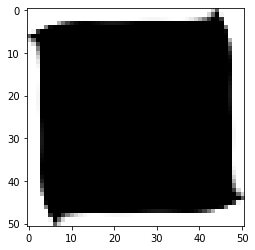

In [148]:
line = np.zeros((51,51))
line[48:] = 1
line[:3] = 1
line[:,:3] = 1
line[:,48:] = 1
swirled = fast_swirl_wand(line, deg=120, interp=True, pad=False)
plt.imshow(swirled, cmap='gray')
plt.savefig(f'Images/no_pad_circle.png', format='png')

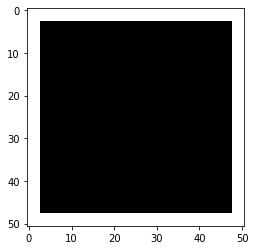

In [155]:
line = np.zeros((51,51))
line[48:] = 1
line[:3] = 1
line[:,:3] = 1
line[:,48:] = 1
plt.imshow(line, cmap='gray')
plt.savefig(f'Images/circle.png', format='png')

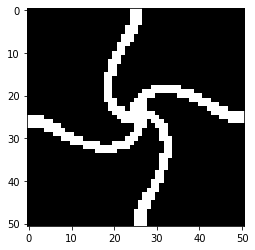

In [153]:
line = np.zeros((51,51))
line[24:27,:] = 1
line[:,24:27] = 1
swirled = fast_swirl_wand(line, deg=120, interp=False, pad=False)
plt.imshow(swirled, cmap='gray')
plt.savefig(f'Images/no_interp_cross.png', format='png')

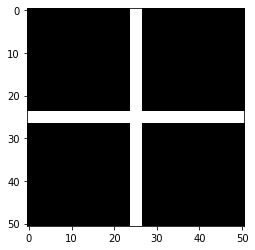

In [154]:
line = np.zeros((51,51))
line[24:27,:] = 1
line[:,24:27] = 1
plt.imshow(line, cmap='gray')
plt.savefig(f'Images/cross.png', format='png')

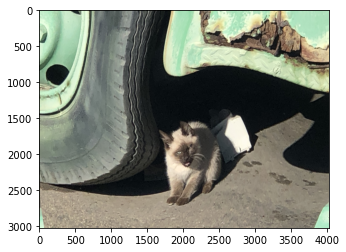

In [151]:
deg = 60

swirled = fast_swirl_wand(im, deg=deg, pad=False, interp=True).astype('uint8')
plt.imshow(swirled)
plt.savefig(f'Images/warped_cat_{deg}.png', format='png')

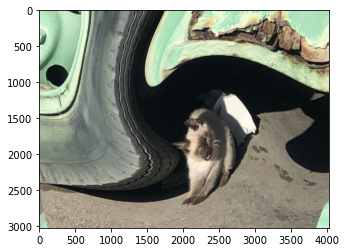

In [134]:
deg = 120

swirled = fast_swirl_wand(im, deg=deg, pad=False, interp=False)
plt.imshow(swirled)
plt.savefig(f'Images/warped_cat_{deg}.png', format='png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


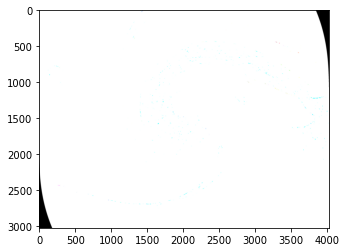

In [149]:
deg = 240

swirled = fast_swirl_wand(im, deg=deg, pad=True, interp=True)
plt.imshow(swirled)
plt.savefig(f'Images/warped_cat_{deg}_pad.png', format='png')

12192768it [04:55, 41195.49it/s]


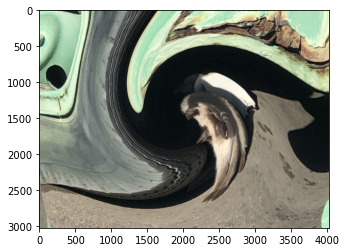

In [20]:
swirled = slow_swirl_wand(im, deg=200)
plt.imshow(swirled)

In [ ]:
swirled
im.shape

(3024, 4032, 3)

In [ ]:
a = np.array([[1, 2, 3],
          [4, 5, 6],
          [7, 8, 9]])
i = a*2
a/i

array([[0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5]])

2601it [00:00, 104637.34it/s]


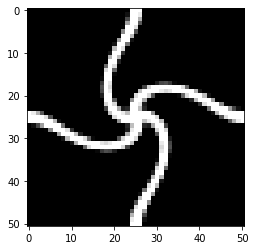

In [17]:
line = np.zeros((51,51))
line[24:27,:] = 1
line[:,24:27] = 1
swirled = slow_swirl_wand(line, deg=120)
plt.imshow(swirled, cmap='gray')

2601it [00:00, 274892.52it/s]


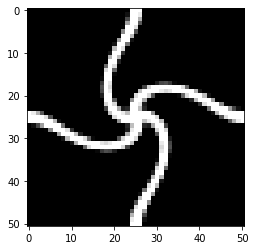

In [18]:
line = np.zeros((51,51))
line[24:27,:] = 1
line[:,24:27] = 1
swirled = faster_interp_swirl_wand(line, deg=120)
plt.imshow(swirled, cmap='gray')

-7.1946599427537805
-7.1946599427537805


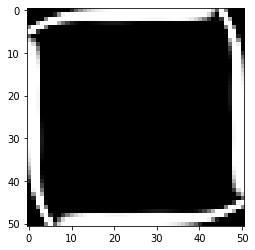

In [121]:
line = np.zeros((51,51))
line[48:] = 1
line[:3] = 1
line[:,:3] = 1
line[:,48:] = 1
swirled = fast_swirl_wand(line, deg=120, pad=True)
plt.imshow(swirled, cmap='gray')

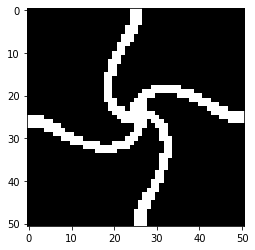

In [ ]:
line = np.zeros((51,51))
line[24:27,:] = 1
line[:,24:27] = 1
swirled = fast_swirl_wand(line, deg=120)
plt.imshow(swirled, cmap='gray')

(51, 51)
(100, 100)


0it [00:00, ?it/s]


TypeError: interpolate() missing 1 required positional argument: 'y'

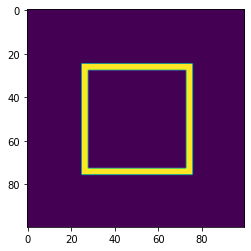

In [92]:
padded = np.zeros((100, 100), dtype='uint8')
padded[25:76, 25:76] = line
plt.imshow(padded)
print(line.shape)
print(padded.shape)
# # print(small.shape)
swirled = slow_swirl_wand(padded, deg=120)
swirled[25,:] = 1
swirled[76,:] = 1
swirled[:,25] = 1
swirled[:,76] = 1
plt.imshow(swirled, cmap="gray")

(189, 252, 3)
(401, 501, 3)


200901it [00:05, 39215.71it/s]


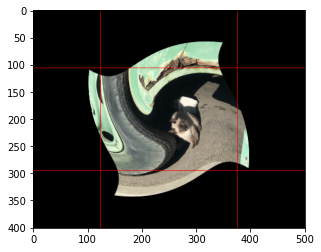

In [ ]:
new_dims = im.shape[1]//16, im.shape[0]//16
small = cv2.resize(im, new_dims)
padded = np.zeros((401, 501, 3), dtype='uint8')
padded[200-94:200+95, 250-126:250+126,:] = small
plt.imshow(padded)
print(small.shape)
print(padded.shape)
# # print(small.shape)
swirled = slow_swirl_wand(padded, deg=120)
swirled[200-94,:] = np.array([255,0,0])
swirled[200+95,:] = np.array([255,0,0])
swirled[:,250-126] = np.array([255,0,0])
swirled[:,250+126] = np.array([255,0,0])
plt.imshow(swirled)

47628it [00:01, 37133.19it/s]


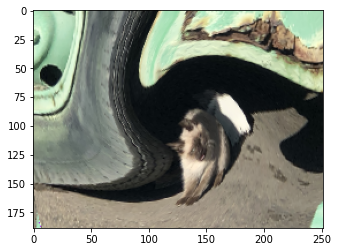

In [ ]:
new_dims = im.shape[1]//16, im.shape[0]//16
small = cv2.resize(im, new_dims)
swirled = slow_swirl_wand(small, deg=120)
plt.imshow(swirled)

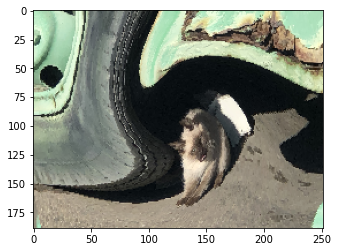

In [ ]:
new_dims = im.shape[1]//16, im.shape[0]//16
small = cv2.resize(im, new_dims)
swirled = fast_swirl_wand(small, deg=120)
plt.imshow(swirled)

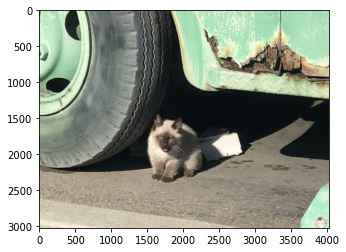

In [ ]:
plt.imshow(im)